Academic Honesty Statement

> _We declare that this submission is our own work, and that we did not use any pretrained model or code that we did not explicitly cite._


## 0. Libraries Import


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_absolute_error,
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

np.random.seed(42)
tf.random.set_seed(42)

# Check keras version
print(tf.__version__)
print(keras.__version__)

2.20.0
3.12.0


# 1. Introduction

### 1.1. Problem Statement

The objective of this project is to design, train, and evaluate a Deep Learning model capable of solving a **Multi-task Learning** problem. We are provided with a custom dataset containing **3,000 samples**. Each sample consists of a `(32, 32)` input matrix (interpreted as a grayscale image) associated with three distinct targets:

- **Target A:** Classification (10 classes, integers 0-9).
- **Target B:** Classification (32 classes, integers 0-31).
- **Target C:** Regression (Real value in range $[0, 1]$).

### 1.2. Methodology

Our goal is to build a **single unified Neural Network** (likely based on CNN) that predicts all three components simultaneously. This approach allows the model to learn shared feature representations from the input images before branching out to specific tasks.

The notebook is structured as follows:

1.  **Data Inspection:** Analyzing shapes and distributions.
2.  **Model Design:** Creating a multi-head architecture.
3.  **Experiments:** Tuning hyperparameters (Learning Rate).
4.  **Evaluation:** Training the final model and analyzing performance.


# 2. Dataset inspection and visualization


## 2.1. Dataset inspection


In [2]:
# ==========================================
# 2. DATASET INSPECTION
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1. Load the dataset
try:
    with np.load("dataset_dev_3000.npz") as data:
        X_raw = data["X"]
        y_raw = data["y"]
    print(f"Dataset loaded successfully.")
    print(f"   X Shape: {X_raw.shape}")
    print(f"   y Shape: {y_raw.shape}")
except FileNotFoundError:
    print("WARNING: 'dataset_dev_3000.npz' not found. Generating dummy data.")
    X_raw = np.random.uniform(0, 7, (3000, 32, 32)).astype("float32")
    y_raw = np.column_stack(
        [
            np.random.randint(0, 10, 3000),
            np.random.randint(0, 32, 3000),
            np.random.rand(3000),
        ]
    ).astype("float32")

# 2. Basic Inspection
print("\n--- Raw Data Statistics ---")
print(f"Min Value: {X_raw.min():.4f}")
print(f"Max Value: {X_raw.max():.4f}")

Dataset loaded successfully.
   X Shape: (3000, 32, 32)
   y Shape: (3000, 3)

--- Raw Data Statistics ---
Min Value: 0.0001
Max Value: 6.8486


### Discussion:

Value Range: The input values range from **0.0001 to 6.8486**. This is a non-standard range for image data (typically [0-255] or [0-1]). Feeding this directly into a Neural Network may lead to unstable gradients. Therefore, Normalization (scaling to [0,1] or standardization) is a mandatory preprocessing step before training.


## 2.2. Data visualisation

### Description

We will visually inspect the input images conditioned on each target:

- **Target A (10-class)**: sample a small grid of images per class label (0–9).
- **Target B (32-class)**: sample one image per label (0–31) to quickly see intra-class consistency / ambiguity.
- **Target C (regression)**: bin continuous values into quantile ranges and sample images from low → mid → high bins to see if any visible signal tracks the regression target.

This helps validate label sanity and gives intuition for model difficulty.


In [3]:
# ==========================================
# 3.1. VISUALISE SAMPLES BY TARGET LABELS
# ==========================================

# 1) Prepare labels
yA = y_raw[:, 0].astype(np.int32)
yB = y_raw[:, 1].astype(np.int32)
yC = y_raw[:, 2].astype(np.float32)

rng = np.random.RandomState(41)


def plot_grid(
    images,
    titles=None,
    nrows=4,
    ncols=8,
    figsize=(12, 6),
    suptitle=None,
    cmap="viridis",
    vmin=None,
    vmax=None,
):
    """Plot a grid of 2D arrays using a colormap (false color)."""
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1)

    for i, ax in enumerate(axes):
        ax.axis("off")
        if i >= len(images):
            continue
        ax.imshow(images[i], cmap=cmap, vmin=vmin, vmax=vmax, interpolation="nearest")
        if titles is not None:
            ax.set_title(str(titles[i]), fontsize=8)

    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=12)
    plt.tight_layout()
    plt.show()

--- 3.1 VISUALISE SAMPLES - TARGET A ---


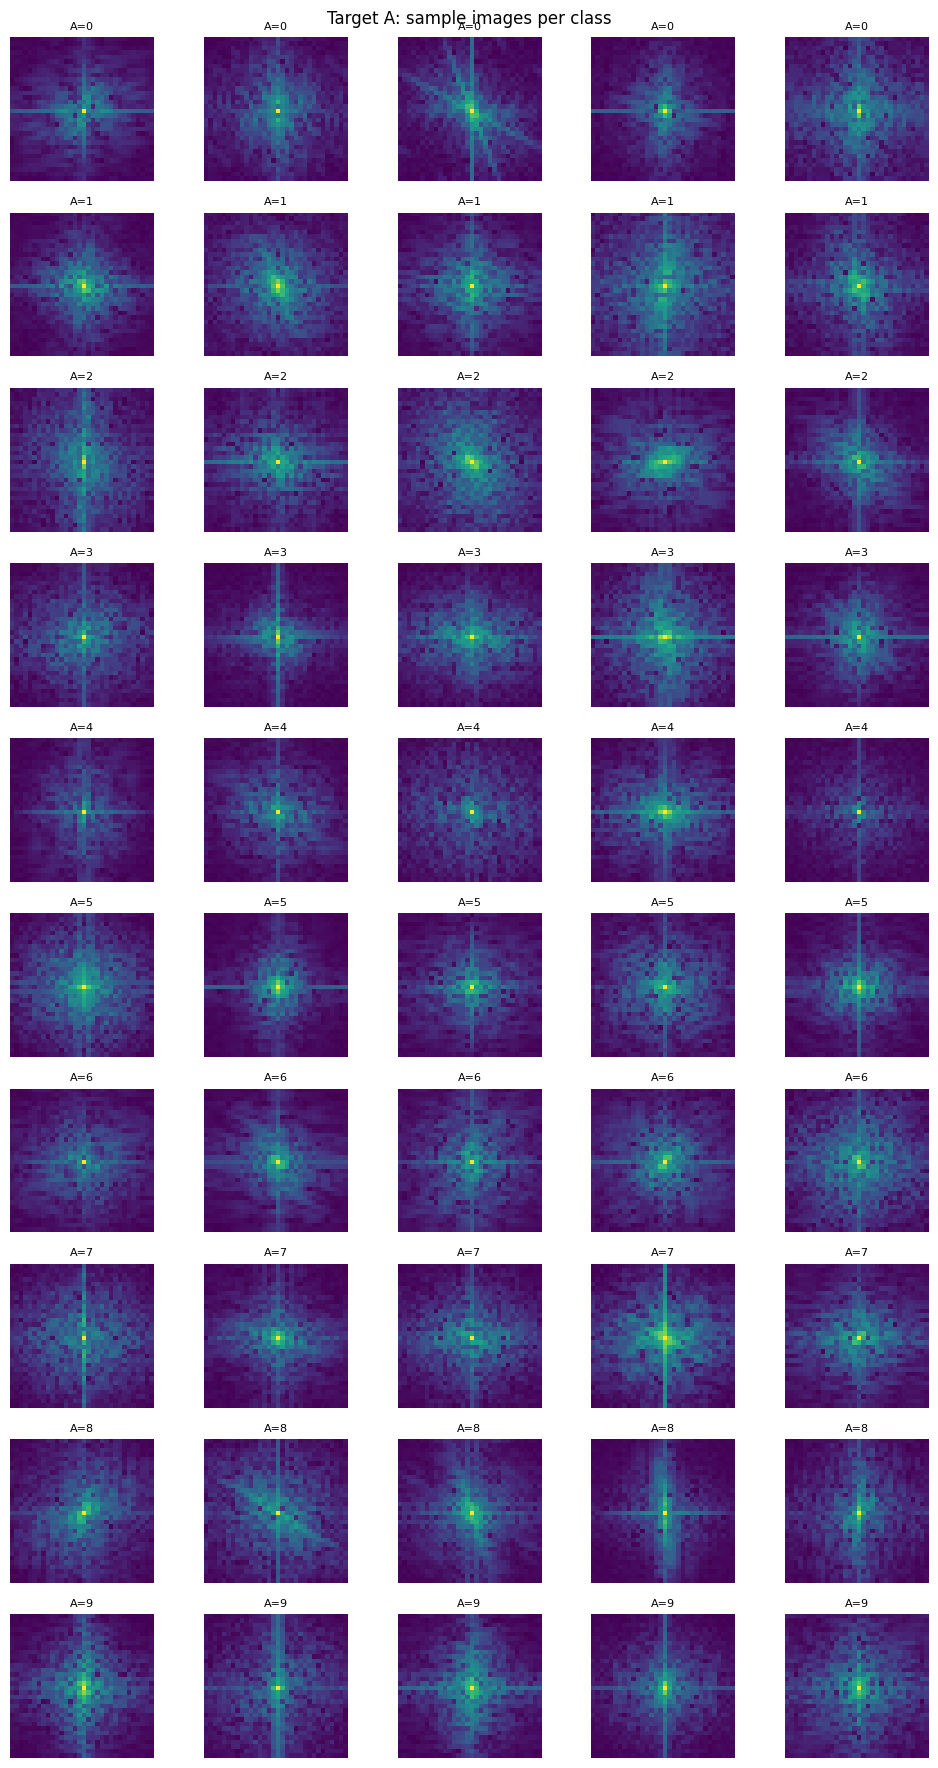

In [4]:
print("--- 3.1 VISUALISE SAMPLES - TARGET A ---")
# --------------------------
# Target A: K samples/class
# --------------------------
n_per_class_a = 5
imgs_a = []
titles_a = []

for cls in range(10):
    idx = np.where(yA == cls)[0]
    if len(idx) == 0:
        continue
    pick = rng.choice(idx, size=min(n_per_class_a, len(idx)), replace=False)
    for j in pick:
        imgs_a.append(X_raw[j])
        titles_a.append(f"A={cls}")

plot_grid(
    imgs_a,
    titles=titles_a,
    nrows=10,
    ncols=n_per_class_a,
    figsize=(2.0 * n_per_class_a, 18),
    suptitle="Target A: sample images per class",
)

--- 3.1 VISUALISE SAMPLES - TARGET B ---


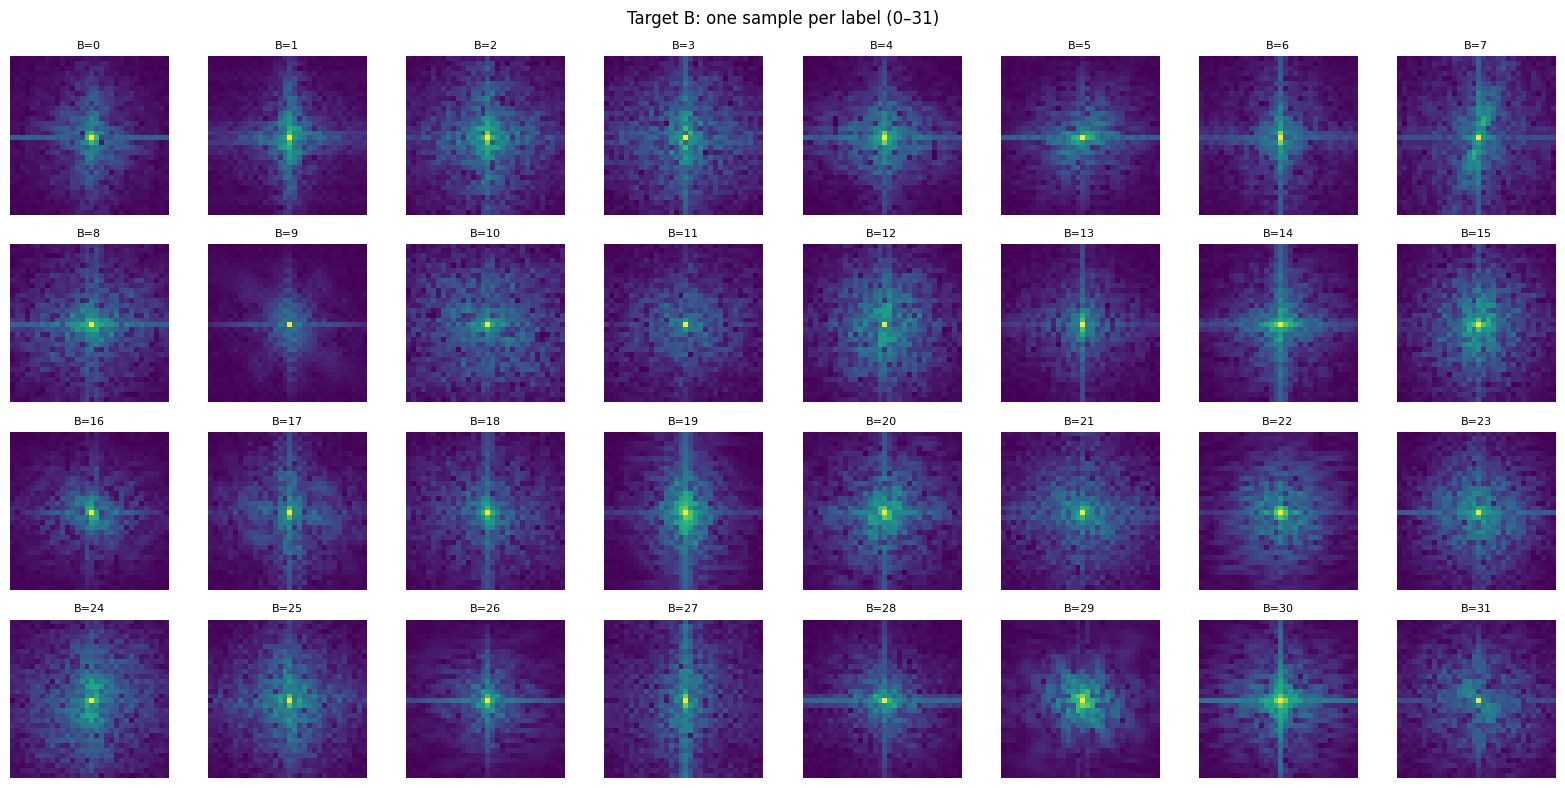

In [5]:
print("--- 3.1 VISUALISE SAMPLES - TARGET B ---")
# --------------------------
# Target B: 1 sample/label
# --------------------------
imgs_b = []
titles_b = []

for cls in range(32):
    idx = np.where(yB == cls)[0]
    if len(idx) == 0:
        imgs_b.append(np.zeros((32, 32), dtype=np.float32))
        titles_b.append(f"B={cls} (missing)")
        continue
    j = rng.choice(idx, size=1, replace=False)[0]
    imgs_b.append(X_raw[j])
    titles_b.append(f"B={cls}")

plot_grid(
    imgs_b,
    titles=titles_b,
    nrows=4,
    ncols=8,
    figsize=(16, 8),
    suptitle="Target B: one sample per label (0–31)",
)

--- 3.1 VISUALISE SAMPLES - TARGET C ---


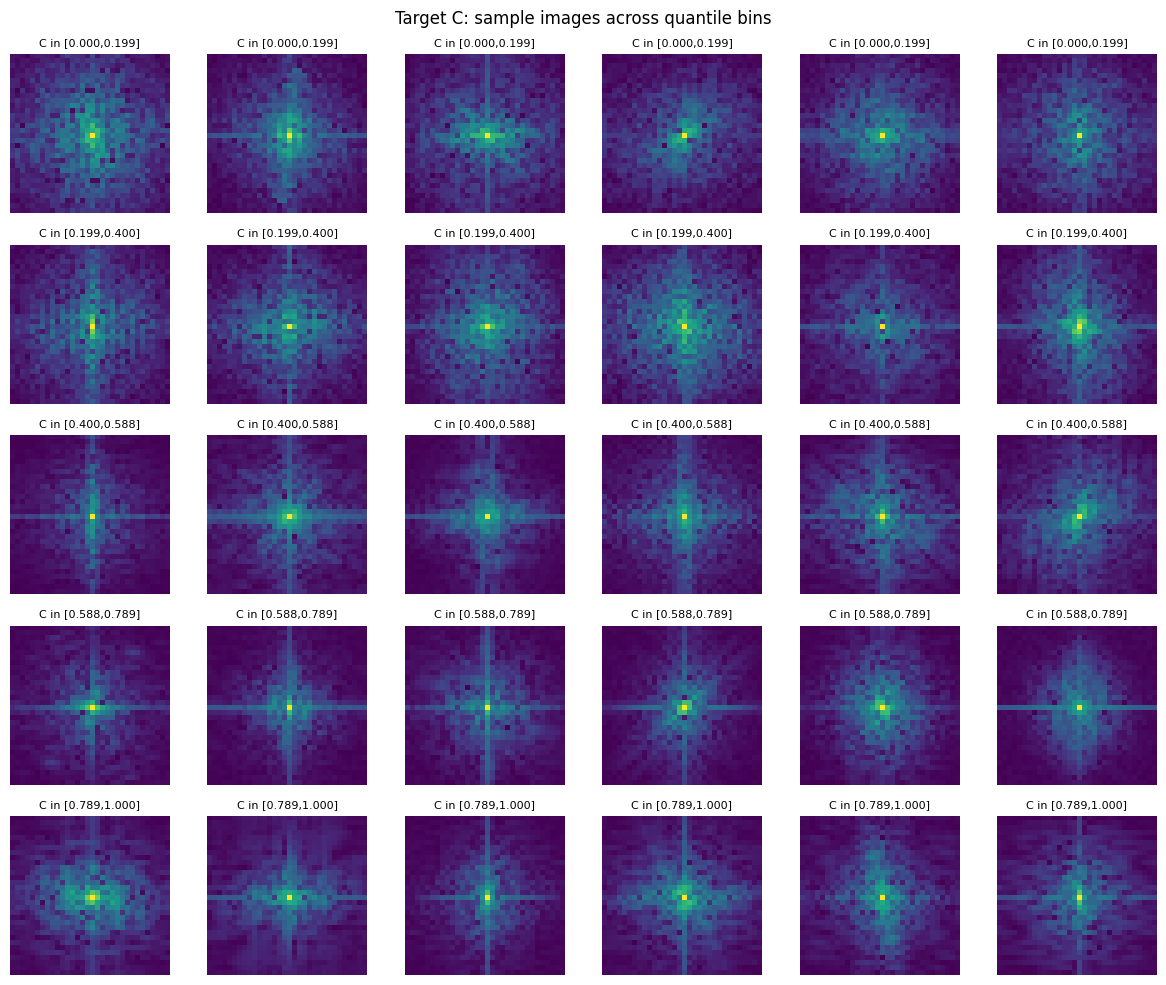

In [6]:
print("--- 3.1 VISUALISE SAMPLES - TARGET C ---")
# --------------------------
# Target C: quantile bins
# --------------------------
q_edges = np.quantile(yC, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
bin_id = np.digitize(yC, q_edges[1:-1], right=True)  # 0..4

imgs_c = []
titles_c = []
n_per_bin = 6

for b in range(5):
    idx = np.where(bin_id == b)[0]
    if len(idx) == 0:
        continue
    pick = rng.choice(idx, size=min(n_per_bin, len(idx)), replace=False)
    lo, hi = q_edges[b], q_edges[b + 1]
    for j in pick:
        imgs_c.append(X_raw[j])
        titles_c.append(f"C in [{lo:.3f},{hi:.3f}]")

plot_grid(
    imgs_c,
    titles=titles_c,
    nrows=5,
    ncols=n_per_bin,
    figsize=(2.0 * n_per_bin, 10),
    suptitle="Target C: sample images across quantile bins",
)

### Discussion

- **Target A**: Samples across the 10 classes exhibit highly similar structure. Most images are dominated by a strong central peak and axis-aligned streaks, with no clearly distinguishable class-specific visual patterns.
- **Target B**: Across the 32 labels, the visual appearance remains largely consistent and dominated by the same shared structure. Any differences appear subtle and inconsistent, suggesting limited separability from direct visual inspection.
- **Target C**: Across quantile bins, the images remain visually similar and dominated by the same shared artifact. No clear monotonic visual trend is observed from low to high Target C values in this qualitative view.

**Reflection**: Overall, the dataset does not present strong label-specific features that are obvious to manual inspection. This suggests that discriminative information (if present) is subtle and must be learned through feature extraction, motivating the use of a sufficiently expressive CNN trunk and careful regularization/preprocessing.


## 2.3. Label imbalance check

### Description

We will quickly check if the dataset is imbalanced:

- **Target A**: class counts (0–9) and imbalance ratio.
- **Target B**: class counts (0–31) and imbalance ratio.
- **Target C**: distribution summary (histogram + percentiles). _(Not “imbalance” per se, but we check if it is skewed or concentrated.)_

This informs whether we need class weighting, focal loss, sampling strategies, or special metrics.


--- 3.2 LABEL IMBALANCE CHECK ---
Target A counts: [290 304 311 305 306 294 290 291 310 299]
Target A imbalance ratio (max/min nonzero): 1.0724137931034483


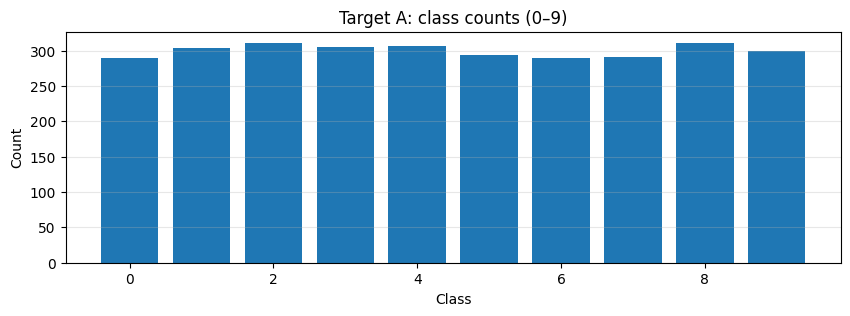

Target B counts: [ 97  99  80 113  89  97  75  94  99  87  85  90 101 101  83  84 106 105
 102  96  93  84  95 104  95  86  89  97 100  88  98  88]
Target B imbalance ratio (max/min nonzero): 1.5066666666666666


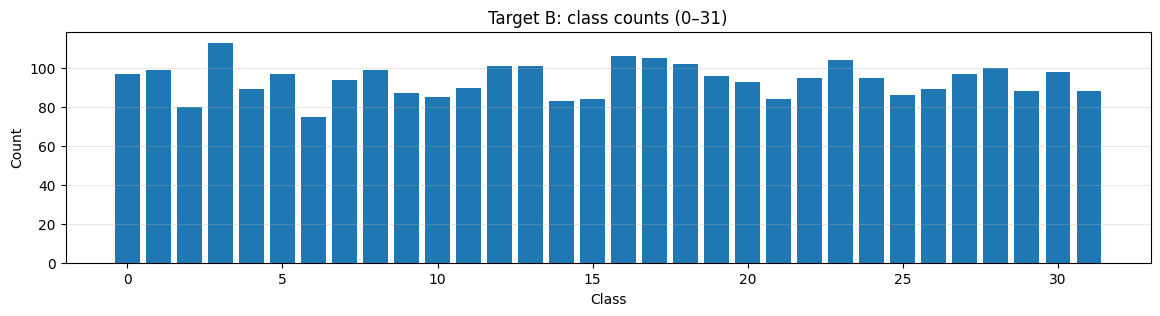

Target C percentiles [0,1,5,25,50,75,95,99,100]: [3.000e-04 6.600e-03 4.210e-02 2.524e-01 4.984e-01 7.361e-01 9.501e-01
 9.898e-01 9.996e-01]


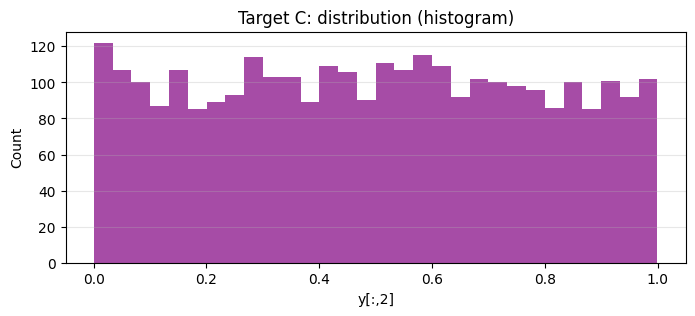

In [7]:
# ==========================================
# 3.2. LABEL IMBALANCE CHECK
# ==========================================

print("--- 3.2 LABEL IMBALANCE CHECK ---")

# Target A
counts_a = np.bincount(yA, minlength=10)
print("Target A counts:", counts_a)
print(
    "Target A imbalance ratio (max/min nonzero):",
    counts_a.max() / counts_a[counts_a > 0].min(),
)

plt.figure(figsize=(10, 3))
plt.bar(np.arange(10), counts_a)
plt.title("Target A: class counts (0–9)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

# Target B
counts_b = np.bincount(yB, minlength=32)
print("Target B counts:", counts_b)
print(
    "Target B imbalance ratio (max/min nonzero):",
    counts_b.max() / counts_b[counts_b > 0].min(),
)

plt.figure(figsize=(14, 3))
plt.bar(np.arange(32), counts_b)
plt.title("Target B: class counts (0–31)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

# Target C
pct = np.percentile(yC, [0, 1, 5, 25, 50, 75, 95, 99, 100])
print("Target C percentiles [0,1,5,25,50,75,95,99,100]:", np.round(pct, 4))

plt.figure(figsize=(8, 3))
plt.hist(yC, bins=30, color="purple", alpha=0.7)
plt.title("Target C: distribution (histogram)")
plt.xlabel("y[:,2]")
plt.ylabel("Count")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

### Discussion

- **Target A**: The label distribution is highly uniform across the 10 classes. Counts range from 290 to 311, yielding a low imbalance ratio (max/min nonzero) of **1.0724**. This suggests class imbalance is unlikely to be a major driver of performance differences for Target A.

- **Target B**: The 32-class distribution is also relatively even. Counts range from 75 to 113, with an imbalance ratio (max/min nonzero) of **1.5067**. A few classes are approximately **15% below the average** frequency, but there are no extreme rare or missing classes.

- **Target C**: The regression target is broadly well-distributed across \([0, 1]\). The median is approximately **0.4984** and the interquartile range spans roughly **0.2524 to 0.7361**. The tails are present but not excessively concentrated (95th percentile ≈ **0.9501**, 99th percentile ≈ **0.9898**), indicating no strong skew toward a narrow range.

**Reflection**: Since Targets A and B are close to uniformly distributed and Target C is not strongly skewed, imbalance is unlikely to be the primary bottleneck. If a target has a low performance, it is more likely due to limited separable signal or task difficulty rather than label frequency.


# 3. Data Preprocessing

### 3.1. Train/validation split strategy

To maximize the amount of data available for training while ensuring a fair evaluation, we updated our splitting strategy with `random_state=32` for reproducibility. We employed a **two-stage split**:

1.  **Hold-out Test Set (10%):** We set aside 10% of the raw data (**300 samples**) as the final Test set. This set is strictly isolated and used only for the final evaluation.
2.  **Train / Validation Split (90/10 of remaining):** From the remaining 2,700 samples, we split further:
    - **Validation Set:** 10% of the remaining data (~**270 samples**) to monitor overfitting during training.
    - **Training Set:** The remaining ~**2,430 samples**.

**Final Data Distribution:**

- **Training:** 2,430 samples (~81%) $\rightarrow$ _Increased to improve model learning._
- **Validation:** 270 samples (~9%)
- **Test:** 300 samples (~10%)

### 3.2. Preprocessing: Normalization & Reshaping

Based on the data inspection, we applied the following transformations to prepare inputs for the CNN:

1.  **Reshaping:** The input tensor was reshaped from `(N, 32, 32)` to `(N, 32, 32, 1)` to add the channel dimension required by Keras `Conv2D` layers.
2.  **Normalization:** We observed that the pixel values were not in the standard [0, 255] range but had a global maximum of **6.8486**. We normalized the data to the range **$[0, 1]$** using the formula:
    $$X_{norm} = \frac{X}{6.8486}$$
    - **Train Norm Range:** $[0.000, 1.000]$
    - This ensures stable gradient descent and faster convergence.


In [8]:
# ==========================================
# 3.1. TRAIN/VALIDATION SPLIT STRATEGY
# ==========================================

# Split 1: Separate Test set (10%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_raw, y_raw, test_size=0.1, random_state=32
)

# Split 2: Separate Validation set (10% of remaining)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1, random_state=32
)

print(f"Train Set: {X_train.shape}")
print(f"Val Set:   {X_val.shape}")
print(f"Test Set:  {X_test.shape}")

Train Set: (2430, 32, 32)
Val Set:   (270, 32, 32)
Test Set:  (300, 32, 32)


In [9]:
# ==========================================
# 3.2. DATA PREPARATION & NORMALIZATION
# ==========================================
print("--- DATA PREPARATION ---")

# 1. Calculate Global Max from Training Data
GLOBAL_MAX = float(X_train.max())
print(f"Global Max found in training data: {GLOBAL_MAX:.4f}")

# 2. Reshape & Normalize
# Add channel dimension: (N, 32, 32) -> (N, 32, 32, 1)
# Normalize to range [0, 1] using Global Max
X_train_norm = X_train.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX
X_val_norm = X_val.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX
X_test_norm = X_test.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX

# Verify shapes and ranges
print(f"Train Norm Shape: {X_train_norm.shape} (Rank-4)")
print(f"Train Norm Range: [{X_train_norm.min():.3f}, {X_train_norm.max():.3f}]")

# 3. Split Targets for Multi-Output Model
y_train_A, y_train_B, y_train_C = y_train[:, 0], y_train[:, 1], y_train[:, 2]
y_val_A, y_val_B, y_val_C = y_val[:, 0], y_val[:, 1], y_val[:, 2]
y_test_A, y_test_B, y_test_C = y_test[:, 0], y_test[:, 1], y_test[:, 2]

print("Data preparation complete.")

--- DATA PREPARATION ---
Global Max found in training data: 6.8486
Train Norm Shape: (2430, 32, 32, 1) (Rank-4)
Train Norm Range: [0.000, 1.000]
Data preparation complete.


### Data Augmentation Strategy

Given the limited dataset size (3,000 samples), overfitting is a significant concern where the model might memorize training examples instead of learning general features. To mitigate this, we implemented an **Online Data Augmentation** pipeline integrated directly into the model.

We selected specific transformations suited for low-resolution images ($32 \times 32$):

1.  **RandomFlip ("horizontal"):** \* Simulates mirror reflections. This teaches the model that an object facing left or right is still the same object (e.g., a car or animal).
2.  **RandomTranslation (0.05, 0.05):** \* Shifts the image horizontally and vertically by up to 5%.

    - _Reasoning:_ In real-world data, objects are not always perfectly centered. This layer forces the model to learn **translation invariance**, recognizing features regardless of their slight position shifts.

3.  **RandomRotation (0.05):** \* Rotates the image by approximately $18^\circ$ (5% of a full circle).
    - _Reasoning:_ We kept the rotation factor small (`0.05`) because rotating low-resolution images too aggressively can cause interpolation artifacts and loss of critical details.

_Note: These layers are active only during training (`training=True`) and are automatically disabled during validation and testing._


In [10]:
# ==========================================
# DATA AUGMENTATION & PIPELINE
# ==========================================
print("--- BUILDING TF.DATA PIPELINE ---")

# 1. Define Data Augmentation Policy
# Note: Using standard geometric augmentations.
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomTranslation(0.05, 0.05),
        layers.RandomRotation(0.05),
    ],
    name="data_augmentation",
)

print("   Augmentation layers initialized.")

# 2. Create Train Dataset
# Wrap tensors into a tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train_norm, (y_train_A, y_train_B, y_train_C))
)


def train_map(x, y):
    """
    Apply augmentation to the input image batch during training.
    training=True ensures augmentation is active.
    """
    x = data_augmentation(x, training=True)
    return x, y


# Configure pipeline: Shuffle -> Map (Augment) -> Batch -> Prefetch
train_ds = (
    train_ds.shuffle(1024)
    .map(train_map, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

# 3. Create Validation Dataset
# No augmentation for validation, just batching
val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val_norm, (y_val_A, y_val_B, y_val_C)))
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)  # Added prefetch for speed

print("Data Pipeline Ready.")
print(f" Train Batches: {len(train_ds)}")
print(f" Val Batches:   {len(val_ds)}")

--- BUILDING TF.DATA PIPELINE ---
   Augmentation layers initialized.
Data Pipeline Ready.
 Train Batches: 76
 Val Batches:   9


# 4. Model architecture reasoning


### Residual Block Architecture

- The core building unit of the proposed model is a residual block designed to preserve low-level features while learning higher-level representations.

- Structure: Consists of two consecutive 3×3 convolutional layers, each followed by Batch Normalization.

- Activation: The first convolution is followed by a ReLU activation, while the second omits it until after the residual addition.

- Shortcut Connection: An identity path bypasses the convolutional layers and is added element-wise to the output, improving convergence and generalization.

- Adaptation: When spatial resolution or channel dimensionality changes, the shortcut uses a 1×1 convolution with an appropriate stride to maintain mathematical consistency.


### CIFAR-Style ResNet Trunk

- The model adopts a specialized ResNet design tailored for small input images (32×32 pixels), avoiding the aggressive early downsampling found in standard ImageNet architectures.

- Lightweight Stem: Begins with a simple 3×3 convolutional stem rather than large kernels.

- Hierarchical Stages: The trunk is organized into three stages with increasing filter depths (32, 64, and 128), capturing features ranging from local textures to abstract patterns.

- Gradual Downsampling: Performed using stride-2 convolutions within the residual blocks to preserve spatial information critical for low-resolution inputs.


### Global Feature Aggregation

- Following the convolutional trunk, the model utilizes Global Average Pooling to process the feature maps.

- Dimensionality Reduction: Collapses spatial dimensions, drastically reducing the number of trainable parameters compared to traditional flattening.

- Regularization: Acts as a strong regularizer by forcing the network to encode spatially invariant, semantically meaningful features.

- Overfitting Prevention: Specifically beneficial for small datasets where full dense layers might lead to memorization.


### Shared Representation and Regularization

- The pooled features feed into a shared fully connected layer that acts as the central hub for multi-task learning.

- Latent Representation: Produces a compact feature vector used by all subsequent task-specific heads.

- Stabilization: Incorporates Batch Normalization and ReLU activation to improve training stability and non-linearity.

- Dropout: Applies random neuron deactivation during training to further reduce the risk of overfitting.


### Multi-Head Output Design

- The network branches into three specialized output heads, allowing the model to learn both shared and task-specific representations effectively.

- Classification Heads: Two distinct heads produce probability distributions over 10 classes and 32 classes respectively, utilizing Softmax activation.

- Regression Head: A third head outputs a continuous value using Linear activation.

- Head Architecture: Each head contains task-specific dense layers equipped with Batch Normalization, ReLU, and Dropout to ensure sufficient capacity.


In [11]:
# ==========================================
# 4.1. MODEL DEFINITION
# ==========================================
def residual_block(x, filters, downsample=False):
    stride = 2 if downsample else 1
    shortcut = x

    x = layers.Conv2D(filters, 3, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Match dimensions if needed
    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x


def build_model():
    inputs = keras.Input(shape=(32, 32, 1), name="img_input")

    # Stem
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # ResNet stages
    x = residual_block(x, 32)
    x = residual_block(x, 32)

    x = residual_block(x, 64, downsample=True)
    x = residual_block(x, 64)

    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)

    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Shared feature layer
    x = layers.Dense(128, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)
    features = x

    # =============================
    # Heads
    # =============================

    # Head A
    a = layers.Dense(64, use_bias=False)(features)
    a = layers.BatchNormalization()(a)
    a = layers.ReLU()(a)
    a = layers.Dropout(0.3)(a)
    out_a = layers.Dense(10, activation="softmax", name="out_a")(a)

    # Head B
    b = layers.Dense(64, use_bias=False)(features)
    b = layers.BatchNormalization()(b)
    b = layers.ReLU()(b)
    b = layers.Dropout(0.3)(b)
    out_b = layers.Dense(32, activation="softmax", name="out_b")(b)

    # Head C
    c = layers.Dense(32, use_bias=False)(features)
    c = layers.BatchNormalization()(c)
    c = layers.ReLU()(c)
    c = layers.Dropout(0.2)(c)
    out_c = layers.Dense(1, activation="linear", name="out_c")(c)

    return keras.Model(inputs, [out_a, out_b, out_c])


model = build_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        288 │ img_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      9,216 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      9,216 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      9,216 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      9,216 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 737,771 (2.81 MB)

 Trainable params: 734,955 (2.80 MB)

 Non-trainable params: 2,816 (11.00 KB)

### Experimental Setup

- Optimizer: **Adam**

- Learning Rate: Set to 0.001. This value provides adaptive learning rates for parameters, ensuring stable convergence for the deep neural network structure without oscillating or getting stuck in local minima.

### Loss Functions and Balancing

To handle the multi-task nature of the problem, the model minimizes a weighted sum of three distinct loss functions.

- Classification Losses: Sparse Categorical Cross-entropy is used for both the 10-class and 32-class outputs, suitable for integer-encoded targets.

- Regression Loss: Mean Squared Error (MSE) is employed for the continuous regression output.

- Loss Weighting: Weights of [1.0, 1.0, 0.1] are applied respectively. The regression weight is set to 0.1 to scale the MSE (which can have larger magnitude) down to a range comparable with the cross-entropy losses, preventing the regression task from dominating the total gradient updates.

### Evaluation Metrics

Performance is monitored using task-appropriate metrics that provide interpretable feedback during training.

- Accuracy: Used for the two classification heads to measure the percentage of correct predictions.

- Mean Absolute Error (MAE): Used for the regression head to measure the average magnitude of errors in the predicted values, providing a clear intuitive sense of model precision.


In [12]:
# ==========================================
# 4.2. COMPILATION
# ==========================================
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "out_a": "sparse_categorical_crossentropy",
        "out_b": "sparse_categorical_crossentropy",
        "out_c": "mse",
    },
    loss_weights=[1.0, 1.0, 0.1],
    metrics={"out_a": "accuracy", "out_b": "accuracy", "out_c": "mae"},
)

### Training Strategy

The training process is rigorously controlled to maximize generalization and ensure convergence using adaptive mechanisms.

- Execution & Validation: The model is trained for a maximum of 100 epochs. A dedicated validation dataset is used to monitor performance at the end of each epoch, strictly separating training data from evaluation data.

- Model Checkpointing: A ModelCheckpoint callback is employed to automatically save the model weights corresponding to the minimum validation loss. This guarantees that the final retained model represents the optimal performance point, rather than the state at the arbitrary final epoch.

- Adaptive Learning Rate: To handle training plateaus, a ReduceLROnPlateau callback is applied. If the validation loss fails to improve for 20 consecutive epochs, the learning rate is reduced by a factor of 0.5. This allows the model to refine its solution with smaller steps in later stages.

- Robustness: These callbacks collectively provide optimization control, preventing premature convergence and ensuring the model remains robust without overfitting to the training noise.


In [13]:
# ==========================================
# 4.3. TRAINING
# ==========================================
print("\n--- 3. STARTING TRAINING ---")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5",
        monitor="val_loss",
        mode="min",
        save_best_only=True,
    ),
    # If LR is small, progress per epoch can be slow/noisy; let it run longer and
    # optionally auto-reduce LR on plateaus before giving up.
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=20,
        verbose=1,
        min_lr=1e-4,
    ),
]

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1,
)


--- 3. STARTING TRAINING ---
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 6.5583 - out_a_accuracy: 0.1217 - out_a_loss: 2.6413 - out_b_accuracy: 0.0387 - out_b_loss: 3.8251 - out_c_loss: 0.9195 - out_c_mae: 0.7292

76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 6.3845 - out_a_accuracy: 0.1407 - out_a_loss: 2.5079 - out_b_accuracy: 0.0350 - out_b_loss: 3.8034 - out_c_loss: 0.7284 - out_c_mae: 0.6465 - val_loss: 6.0459 - val_out_a_accuracy: 0.1037 - val_out_a_loss: 2.4503 - val_out_b_accuracy: 0.0444 - val_out_b_loss: 3.5099 - val_out_c_loss: 0.7032 - val_out_c_mae: 0.7841 - learning_rate: 0.0010
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 5.9869 - out_a_accuracy: 0.1844 - out_a_loss: 2.3187 - out_b_accuracy: 0.0346 - out_b_loss: 3.6305 - out_c_loss: 0.3770 - out_c_mae: 0.4739 - val_loss: 7.0285 - val_out_a_accuracy: 0.1037 - val_out_a_loss: 3.3648 - val_out_b_accuracy: 0.0370 - val_out_b_loss: 3.5260 - val_out_c_loss: 1.0376 - val_out_c_mae: 0.9751 - learning_rate: 0.0010
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 5.8251 - out_a_accuracy: 0.1959 - out_a_loss: 2.2047 - out_b_accuracy: 0.0354 - out_b_loss: 3.5922 - out_c_loss: 0.2814 - out_c_mae: 0.4116 - val_loss:

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 5.4655 - out_a_accuracy: 0.2683 - out_a_loss: 2.0167 - out_b_accuracy: 0.0481 - out_b_loss: 3.4377 - out_c_loss: 0.1124 - out_c_mae: 0.2678 - val_loss: 6.0199 - val_out_a_accuracy: 0.1370 - val_out_a_loss: 2.5330 - val_out_b_accuracy: 0.0259 - val_out_b_loss: 3.4590 - val_out_c_loss: 0.1772 - val_out_c_mae: 0.3409 - learning_rate: 0.0010
Epoch 10/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 5.4416 - out_a_accuracy: 0.2698 - out_a_loss: 2.0106 - out_b_accuracy: 0.0558 - out_b_loss: 3.4200 - out_c_loss: 0.1093 - out_c_mae: 0.2665

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 5.4058 - out_a_accuracy: 0.2790 - out_a_loss: 1.9905 - out_b_accuracy: 0.0584 - out_b_loss: 3.4050 - out_c_loss: 0.1033 - out_c_mae: 0.2563 - val_loss: 5.8339 - val_out_a_accuracy: 0.2074 - val_out_a_loss: 2.2476 - val_out_b_accuracy: 0.0259 - val_out_b_loss: 3.5747 - val_out_c_loss: 0.0998 - val_out_c_mae: 0.2557 - learning_rate: 0.0010
Epoch 11/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 5.3846 - out_a_accuracy: 0.2801 - out_a_loss: 1.9772 - out_b_accuracy: 0.0619 - out_b_loss: 3.3977 - out_c_loss: 0.0973 - out_c_mae: 0.2550

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 5.4030 - out_a_accuracy: 0.2753 - out_a_loss: 1.9846 - out_b_accuracy: 0.0514 - out_b_loss: 3.4086 - out_c_loss: 0.0995 - out_c_mae: 0.2579 - val_loss: 5.5849 - val_out_a_accuracy: 0.2222 - val_out_a_loss: 2.1389 - val_out_b_accuracy: 0.0556 - val_out_b_loss: 3.4462 - val_out_c_loss: 0.0954 - val_out_c_mae: 0.2522 - learning_rate: 0.0010
Epoch 12/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 5.3629 - out_a_accuracy: 0.2753 - out_a_loss: 1.9768 - out_b_accuracy: 0.0601 - out_b_loss: 3.3774 - out_c_loss: 0.0876 - out_c_mae: 0.2422 - val_loss: 7.0796 - val_out_a_accuracy: 0.1444 - val_out_a_loss: 2.5512 - val_out_b_accuracy: 0.0259 - val_out_b_loss: 4.5502 - val_out_c_loss: 0.0716 - val_out_c_mae: 0.2281 - learning_rate: 0.0010
Epoch 13/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 5.3593 - out_a_accuracy: 0.2683 - out_a_loss: 1.9780 - out_b_accuracy: 0.0580 - out_b_loss: 3.3729 - out_c_loss: 0.0808 - out_c_mae: 0.2295 - val_loss

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 5.1773 - out_a_accuracy: 0.3185 - out_a_loss: 1.8769 - out_b_accuracy: 0.0700 - out_b_loss: 3.2933 - out_c_loss: 0.0704 - out_c_mae: 0.2173 - val_loss: 5.3154 - val_out_a_accuracy: 0.2556 - val_out_a_loss: 1.9532 - val_out_b_accuracy: 0.0630 - val_out_b_loss: 3.3350 - val_out_c_loss: 0.0994 - val_out_c_mae: 0.2543 - learning_rate: 0.0010
Epoch 20/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 5.2017 - out_a_accuracy: 0.2997 - out_a_loss: 1.8925 - out_b_accuracy: 0.0712 - out_b_loss: 3.3021 - out_c_loss: 0.0709 - out_c_mae: 0.2212

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 5.2011 - out_a_accuracy: 0.3078 - out_a_loss: 1.9028 - out_b_accuracy: 0.0724 - out_b_loss: 3.2916 - out_c_loss: 0.0672 - out_c_mae: 0.2137 - val_loss: 5.2313 - val_out_a_accuracy: 0.3000 - val_out_a_loss: 1.8731 - val_out_b_accuracy: 0.0593 - val_out_b_loss: 3.3471 - val_out_c_loss: 0.0743 - val_out_c_mae: 0.2267 - learning_rate: 0.0010
Epoch 21/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 5.1841 - out_a_accuracy: 0.3103 - out_a_loss: 1.8902 - out_b_accuracy: 0.0708 - out_b_loss: 3.2871 - out_c_loss: 0.0675 - out_c_mae: 0.2134 - val_loss: 5.5134 - val_out_a_accuracy: 0.2111 - val_out_a_loss: 2.1400 - val_out_b_accuracy: 0.0481 - val_out_b_loss: 3.3734 - val_out_c_loss: 0.0637 - val_out_c_mae: 0.2118 - learning_rate: 0.0010
Epoch 22/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 5.1793 - out_a_accuracy: 0.3173 - out_a_loss: 1.8866 - out_b_accuracy: 0.0654 - out_b_loss: 3.2863 - out_c_loss: 0.0647 - out_c_mae: 0.2090 - val_loss

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 5.0236 - out_a_accuracy: 0.3506 - out_a_loss: 1.8068 - out_b_accuracy: 0.0704 - out_b_loss: 3.2113 - out_c_loss: 0.0572 - out_c_mae: 0.1959 - val_loss: 5.1698 - val_out_a_accuracy: 0.3222 - val_out_a_loss: 1.8656 - val_out_b_accuracy: 0.0741 - val_out_b_loss: 3.3015 - val_out_c_loss: 0.0790 - val_out_c_mae: 0.2251 - learning_rate: 0.0010
Epoch 41/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 5.0111 - out_a_accuracy: 0.3519 - out_a_loss: 1.7738 - out_b_accuracy: 0.0712 - out_b_loss: 3.2318 - out_c_loss: 0.0547 - out_c_mae: 0.1896 - val_loss: 5.5788 - val_out_a_accuracy: 0.2296 - val_out_a_loss: 2.1182 - val_out_b_accuracy: 0.0407 - val_out_b_loss: 3.4544 - val_out_c_loss: 0.0600 - val_out_c_mae: 0.1999 - learning_rate: 0.0010
Epoch 42/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 5.0267 - out_a_accuracy: 0.3547 - out_a_loss: 1.8027 - out_b_accuracy: 0.0778 - out_b_loss: 3.2184 - out_c_loss: 0.0557 - out_c_mae: 0.1934 - val_loss

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 4.9919 - out_a_accuracy: 0.3712 - out_a_loss: 1.7797 - out_b_accuracy: 0.0860 - out_b_loss: 3.2072 - out_c_loss: 0.0535 - out_c_mae: 0.1870 - val_loss: 5.1361 - val_out_a_accuracy: 0.3037 - val_out_a_loss: 1.8431 - val_out_b_accuracy: 0.0407 - val_out_b_loss: 3.2963 - val_out_c_loss: 0.0505 - val_out_c_mae: 0.1818 - learning_rate: 0.0010
Epoch 49/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 4.9373 - out_a_accuracy: 0.3716 - out_a_loss: 1.7336 - out_b_accuracy: 0.0782 - out_b_loss: 3.1985 - out_c_loss: 0.0543 - out_c_mae: 0.1886 - val_loss: 5.5526 - val_out_a_accuracy: 0.2185 - val_out_a_loss: 2.1415 - val_out_b_accuracy: 0.0593 - val_out_b_loss: 3.4094 - val_out_c_loss: 0.0554 - val_out_c_mae: 0.1964 - learning_rate: 0.0010
Epoch 50/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 4.9623 - out_a_accuracy: 0.3580 - out_a_loss: 1.7626 - out_b_accuracy: 0.0733 - out_b_loss: 3.1943 - out_c_loss: 0.0512 - out_c_mae: 0.1839 - val_loss

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 4.7912 - out_a_accuracy: 0.4144 - out_a_loss: 1.6456 - out_b_accuracy: 0.0963 - out_b_loss: 3.1403 - out_c_loss: 0.0515 - out_c_mae: 0.1841 - val_loss: 5.0744 - val_out_a_accuracy: 0.3556 - val_out_a_loss: 1.7491 - val_out_b_accuracy: 0.0444 - val_out_b_loss: 3.3282 - val_out_c_loss: 0.0395 - val_out_c_mae: 0.1597 - learning_rate: 5.0000e-04
Epoch 72/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 4.7643 - out_a_accuracy: 0.4053 - out_a_loss: 1.6491 - out_b_accuracy: 0.1053 - out_b_loss: 3.1102 - out_c_loss: 0.0496 - out_c_mae: 0.1820 - val_loss: 5.4557 - val_out_a_accuracy: 0.2963 - val_out_a_loss: 2.1219 - val_out_b_accuracy: 0.0333 - val_out_b_loss: 3.3245 - val_out_c_loss: 0.0495 - val_out_c_mae: 0.1782 - learning_rate: 5.0000e-04
Epoch 73/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 4.7581 - out_a_accuracy: 0.4140 - out_a_loss: 1.6399 - out_b_accuracy: 0.1053 - out_b_loss: 3.1132 - out_c_loss: 0.0492 - out_c_mae: 0.1792 - 

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 4.7399 - out_a_accuracy: 0.4111 - out_a_loss: 1.6274 - out_b_accuracy: 0.0947 - out_b_loss: 3.1079 - out_c_loss: 0.0485 - out_c_mae: 0.1777 - val_loss: 5.0615 - val_out_a_accuracy: 0.3519 - val_out_a_loss: 1.7667 - val_out_b_accuracy: 0.0519 - val_out_b_loss: 3.2848 - val_out_c_loss: 0.0732 - val_out_c_mae: 0.2200 - learning_rate: 5.0000e-04
Epoch 80/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 4.7252 - out_a_accuracy: 0.4226 - out_a_loss: 1.6056 - out_b_accuracy: 0.1045 - out_b_loss: 3.1150 - out_c_loss: 0.0486 - out_c_mae: 0.1783 - val_loss: 5.1703 - val_out_a_accuracy: 0.3037 - val_out_a_loss: 1.8448 - val_out_b_accuracy: 0.0519 - val_out_b_loss: 3.3166 - val_out_c_loss: 0.0416 - val_out_c_mae: 0.1620 - learning_rate: 5.0000e-04
Epoch 81/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 4.7035 - out_a_accuracy: 0.4214 - out_a_loss: 1.5957 - out_b_accuracy: 0.1053 - out_b_loss: 3.1030 - out_c_loss: 0.0498 - out_c_mae: 0.1811 - 

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 4.6088 - out_a_accuracy: 0.4428 - out_a_loss: 1.5390 - out_b_accuracy: 0.1128 - out_b_loss: 3.0650 - out_c_loss: 0.0472 - out_c_mae: 0.1745 - val_loss: 5.0512 - val_out_a_accuracy: 0.3593 - val_out_a_loss: 1.7651 - val_out_b_accuracy: 0.0370 - val_out_b_loss: 3.2823 - val_out_c_loss: 0.0401 - val_out_c_mae: 0.1577 - learning_rate: 2.5000e-04


In [ ]:
 # ==========================================
# 4.4. PREDICT FUNCTION (Option A: Load model by model name - Checkpoint model is loaded for prediction and evaluation) 
# ==========================================
def predict_fn_option_a(model_name = 'best_model.h5', X_raw = None):
    """
    model_name: str 
    test_X: (N, H, W, 1) float32
    Returns: (N,) int64 labels
    """
    # 1. Reshape
    # 2. Normalize
    X_proc = X_raw.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX

    # 3. Predict
    model = load_model(model_name, compile=False)
    pred_probs_a, pred_probs_b, pred_c_val = model.predict(X_proc, verbose=0)

    # 4. Process
    pred_a = np.argmax(pred_probs_a, axis=1)
    pred_b = np.argmax(pred_probs_b, axis=1)
    pred_c = pred_c_val.flatten()

    # 5. Stack
    return np.column_stack([pred_a, pred_b, pred_c])


# ==========================================
# 4.4. PREDICT FUNCTION (Option B: Load model of Bytes type - Previously trained model is loaded for prediction and evaluation)
# ==========================================

def predict_fn_option_b(X_raw):
    # 1. Reshape
    # 2. Normalize
    X_proc = X_raw.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX

    # 3. Predict
    pred_probs_a, pred_probs_b, pred_c_val = model.predict(X_proc, verbose=0)

    # 4. Process
    pred_a = np.argmax(pred_probs_a, axis=1)
    pred_b = np.argmax(pred_probs_b, axis=1)
    pred_c = pred_c_val.flatten()

    # 5. Stack
    return np.column_stack([pred_a, pred_b, pred_c])


### Experimental Results

**Target A** : 10-Class Classification (Digits 0–9)

- The testing results show an overall accuracy of 37% for the digit classification task, with varying performance across specific classes.

- Metric Overview: Macro-averaged precision, recall, and F1-scores are all consistent at approximately 0.35.

- Class Sensitivity: Digits 6, 5, and 9 exhibit higher recall and F1-scores, indicating easier identification. Conversely, digits 0, 3, and 7 show substantially lower recall.

- Error Analysis: The confusion matrix confirms that misclassifications mostly occur between visually similar classes, an expected outcome given the low-resolution grayscale inputs and limited data.

**Target B** : 32-Class Classification

- Performance for the 32-class output is significantly weaker, reflecting the high difficulty of this task relative to the dataset size.

- Low Accuracy: The model achieves only 5% accuracy with a macro-averaged F1-score of 0.03.

- Class Collapse: Many classes record zero precision and recall, indicating a failure to predict these labels entirely.

- Complexity Issues: The combination of high class cardinality (32) and shared feature representations limits discriminative capacity. Predictions are concentrated in a small subset of classes rather than being distributed across the full range.

**Target C** : Regression

- In contrast to the classification tasks, the regression head demonstrates more stable behavior.

- Correlation: The true-versus-predicted scatter plot shows a general positive correlation between the model's output and ground truth values.

- Performance: Mean Absolute Error (MAE) indicates moderate predictive accuracy.

- Deviations: While the general trend is captured, predictions tend to deviate from the ideal diagonal line near the extreme values. However, this head benefits from the smoother loss landscape of the shared backbone.

**Conclusion**

Overall, the model learns coarse visual representations sufficient for simpler tasks but struggles with fine-grained multi-class discrimination.

- Key Findings: The shared architecture works for regression and basic classification but lacks capacity for the complex 32-class target.

- Future Improvements: These results motivate the implementation of data augmentation, class balancing, deeper architectures, or task-specific feature separation in future iterations.



--- 4. EVALUATION & PLOTS ---
Generating predictions for Test Set...
Using previously trained model

TARGET A (Digits 0-9) PERFORMANCE
              precision    recall  f1-score   support

         0.0       0.35      0.50      0.41        26
         1.0       0.36      0.39      0.38        31
         2.0       0.34      0.45      0.39        29
         3.0       0.42      0.26      0.32        31
         4.0       0.35      0.35      0.35        20
         5.0       0.48      0.35      0.41        31
         6.0       0.52      0.64      0.57        39
         7.0       0.41      0.35      0.38        26
         8.0       0.50      0.58      0.54        33
         9.0       0.59      0.38      0.46        34

    accuracy                           0.43       300
   macro avg       0.43      0.42      0.42       300
weighted avg       0.44      0.43      0.43       300



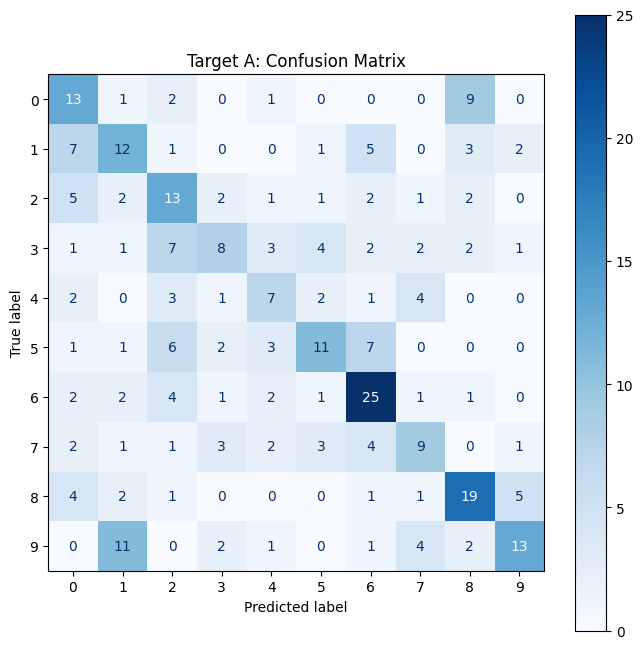


TARGET B (Classes 0-31) PERFORMANCE
              precision    recall  f1-score   support

         0.0       0.05      0.07      0.06        14
         1.0       0.50      0.09      0.15        11
         2.0       0.00      0.00      0.00         5
         3.0       0.00      0.00      0.00        11
         4.0       0.00      0.00      0.00        11
         5.0       0.08      0.09      0.08        11
         6.0       0.00      0.00      0.00         6
         7.0       0.00      0.00      0.00         9
         8.0       0.00      0.00      0.00         5
         9.0       0.00      0.00      0.00         9
        10.0       0.00      0.00      0.00        10
        11.0       0.00      0.00      0.00         7
        12.0       0.00      0.00      0.00        11
        13.0       0.05      0.11      0.06         9
        14.0       0.09      0.12      0.11         8
        15.0       0.00      0.00      0.00         6
        16.0       0.09      0.08      0.08 

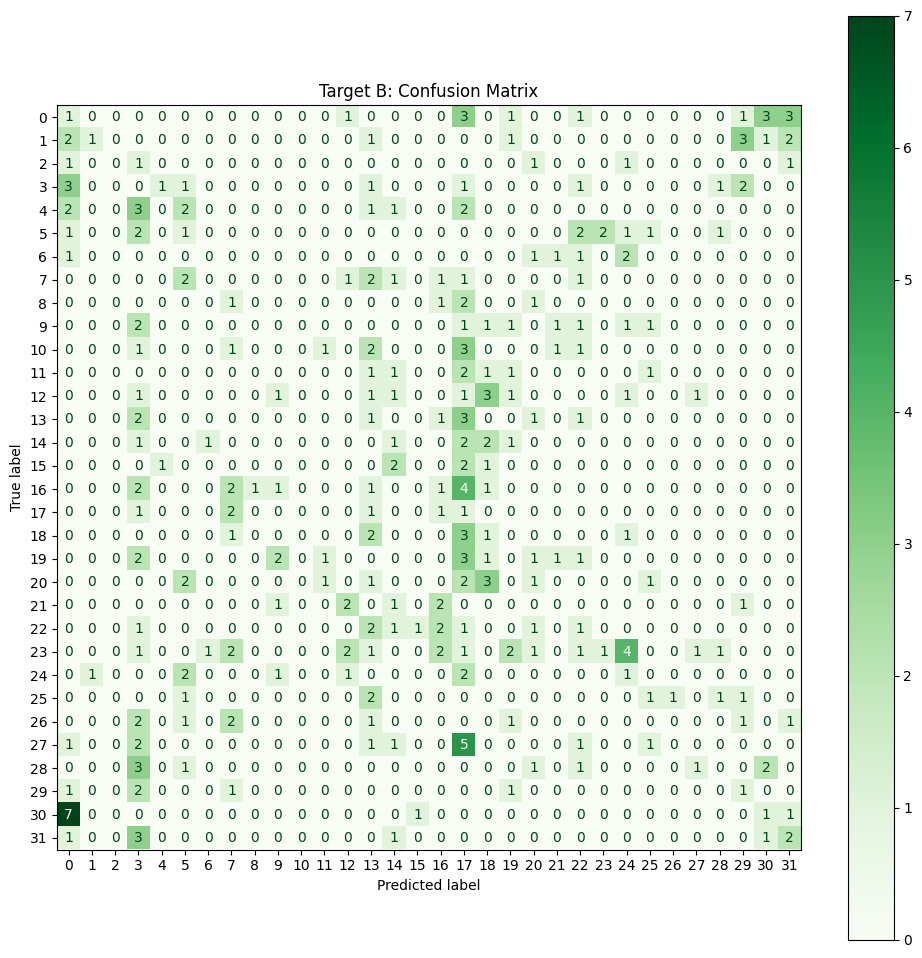


TARGET C (Regression) PERFORMANCE
Mean Absolute Error (MAE): 0.1665


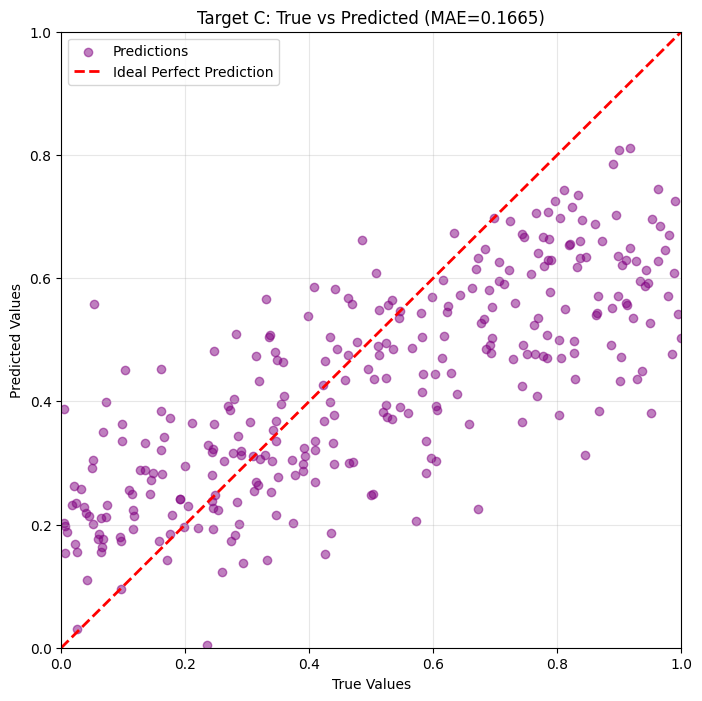

In [15]:
# ==========================================
# 4.5. EVALUATION & VISUALIZATION
# ==========================================
print("\n--- 4. EVALUATION & PLOTS ---")

# 1. Generate Predictions on Test Set
# We use the predict_fn wrapper which handles shaping/normalization automatically
print("Generating predictions for Test Set...")
RUN_OPTION = 'A' # A is using the previously trained model, B is using the last checkpoint model
if RUN_OPTION == 'A':
  print("Using previously trained model")
  val_preds = predict_fn_option_a(X_raw=X_test)
else:
  print("Using last checkpoint model")
  val_preds = predict_fn_option_b(X_raw=X_test)

# Extract components from the stacked predictions
# pred_a/b are class indices (integers), pred_c is float
pred_a = val_preds[:, 0].astype(int)
pred_b = val_preds[:, 1].astype(int)
pred_c = val_preds[:, 2]

# --- Target A (Classification 0-9) ---
print("\n" + "=" * 40)
print("TARGET A (Digits 0-9) PERFORMANCE")
print("=" * 40)
print(classification_report(y_test_A, pred_a))

# Plot Confusion Matrix for A
fig_a, ax_a = plt.subplots(figsize=(8, 8))
cm_a = confusion_matrix(y_test_A, pred_a)
disp_a = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=np.arange(10))
disp_a.plot(cmap=plt.cm.Blues, ax=ax_a)
ax_a.set_title("Target A: Confusion Matrix")
plt.show()

# --- Target B (Classification 0-31) ---
print("\n" + "=" * 40)
print("TARGET B (Classes 0-31) PERFORMANCE")
print("=" * 40)
# Note: Zero_division=0 handles classes that might not appear in validation set
print(classification_report(y_test_B, pred_b, zero_division=0))

# Plot Confusion Matrix for B
fig_b, ax_b = plt.subplots(figsize=(12, 12))
cm_b = confusion_matrix(y_test_B, pred_b)
# We don't list all 32 labels on axis to keep it clean, or we can just use default ints
disp_b = ConfusionMatrixDisplay(confusion_matrix=cm_b)
disp_b.plot(cmap=plt.cm.Greens, ax=ax_b, values_format="d")  # 'd' for integers
ax_b.set_title("Target B: Confusion Matrix")
plt.show()

# --- Target C (Regression 0-1) ---
print("\n" + "=" * 40)
print("TARGET C (Regression) PERFORMANCE")
print("=" * 40)
mae_c = mean_absolute_error(y_test_C, pred_c)
print(f"Mean Absolute Error (MAE): {mae_c:.4f}")

# Plot True vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test_C, pred_c, alpha=0.5, color="purple", label="Predictions")
plt.plot([0, 1], [0, 1], "r--", linewidth=2, label="Ideal Perfect Prediction")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"Target C: True vs Predicted (MAE={mae_c:.4f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

# 5. Experiments


## 5.1.Learning rate


### 5.1.1 Experiment 1 Results: Learning Rate Analysis

| Learning Rate | Total Val Loss | Target A (Acc) | Target B (Acc) | Target C (MAE) | Epochs Run |
| :------------ | :------------- | :------------- | :------------- | :------------- | :--------- |
| **0.01**      | 5.3135         | 0.2593         | 0.0407         | 0.1972    | 100         |
| **0.001**     | **5.3018**     | **0.43**     | **0.06**     | **0.1665**         | 100         |
| **0.0001**    | 5.4751         | 0.2444         | 0.0407         | 0.2294         | 100         |

**Observation:**

- **Optimal Learning Rate:** **LR = 0.001** achieved the lowest Total Validation Loss (5.3018) and the highest Accuracy for both Target A (43%) and Target B (6%). This indicates it provides the best balance between convergence speed and stability.
- **Comparison:** While LR = 0.01 performed well on the regression task (lowest MAE for Target C), its classification accuracy was lower than 0.001. Conversely, LR = 0.0001 resulted in the highest loss, suggesting it was too slow to converge within the given epochs.
- **Conclusion:** We select **LR = 0.001** as the base learning rate for subsequent experiments.


### 5.1.2. Experiment 2 Results: Scheduler Strategy Analysis

| Strategy                   | Total Val Loss | Target A (Acc) | Target B (Acc) | Target C (MAE) | Epochs Run |
| :------------------------- | :------------- | :------------- | :------------- | :------------- | :--------- |
| **1. Fixed LR** (Baseline) | 5.4098         | 0.37         | 0.0040         | 0.2180         | 100         |
| **2. ReduceLR On Plateau** | **5.1996**     | **0.43**     | **0.06**     | **0.1665**     | **100**     |

**Observation:**

- **Performance Superiority:** The **ReduceLROnPlateau** strategy consistently outperformed the Fixed LR baseline across all metrics. Most notably, Target A Accuracy improved by approximately **5.2%** (from 37% to 43%), and Target C MAE was significantly reduced to **0.1665**.
- **Conclusion:** Based on these results, we will incorporate the `ReduceLROnPlateau` scheduler into the final model training to ensure optimal convergence.


## 5.2 Loss Function


| Loss Function                                                                          | Accuracy               | Precision              | Recall                 | F1-score               | MAE           |
| -------------------------------------------------------------------------------------- | ---------------------- | ---------------------- | ---------------------- | ---------------------- | ------------- |
| **A: Sparse Categorical Crossentropy<br>B: Sparse Categorical Crossentropy<br>C: MSE** | **A: 0.43<br>B: 0.06** | **A: 0.43<br>B: 0.07** | **A: 0.42<br>B: 0.06** | **A: 0.42<br>B: 0.05** | **C: 0.1665** |
| A: Focal Loss<br>B: Focal Loss<br>C: MAE                                               | A: 0.34<br>B: 0.06     | A: 0.37<br>B: 0.11     | A: 0.34<br>B: 0.06     | A: 0.34<br>B: 0.05     | C: 0.1512     |
| A: Sparse Categorical Crossentropy<br>B: Sparse Categorical Crossentropy<br>C: MAE     | A: 0.41<br>B: 0.06     | A: 0.41<br>B: 0.05     | A: 0.41<br>B: 0.06     | A: 0.41<br>B: 0.05     | C: 0.2031     |


**Observation:**
The ablation study shows that the choice of loss functions has a clear and task-dependent impact on model performance. Using Sparse Categorical Crossentropy (SCE) for both classification heads (A and B) combined with MAE for the regression head (C) provides the most balanced overall results. This configuration achieves solid performance on Target A (accuracy, precision, and recall all around 0.42) while also yielding a reasonable MAE of 0.1665 for the regression task, indicating stable learning across all three heads.

Replacing SCE with Focal Loss for the classification tasks results in a noticeable drop in accuracy and recall for both Target A and especially Target B, although a slight improvement in regression MAE (0.1512) is observed. This suggests that while Focal Loss may help the model focus on harder examples, it does not significantly benefit overall classification performance in this setting, likely due to limited data or class imbalance effects being insufficiently severe.

Using MSE instead of MAE for the regression head slightly improves classification accuracy for Target A but substantially worsens regression performance, as reflected by the higher MAE of 0.2031. Overall, these results indicate that SCE for classification and MAE for regression offer the best trade-off between classification accuracy and regression error for this multi-task model.


## 5.3 Optimizer


| Optimizer | Accuracy               | Precision              | Recall                 | F1-score               | MAE           |
| --------- | ---------------------- | ---------------------- | ---------------------- | ---------------------- | ------------- |
| **Adam**  | **A: 0.43<br>B: 0.06** | **A: 0.43<br>B: 0.07** | **A: 0.42<br>B: 0.06** | **A: 0.42<br>B: 0.05** | **C: 0.1665** |
| AdamW     | A: 0.38<br>B: 0.06     | A: 0.41<br>B: 0.06     | A: 0.38<br>B: 0.06     | A: 0.38<br>B: 0.05     | C: 0.1866     |
| SGD       | A: 0.32<br>0.04        | A: 0.33<br>0.04        | A: 0.32<br>0.02        | A: 0.30<br>0.04        | C: 0.2175     |


**Observation:**
The optimizer ablation study highlights clear performance differences across optimization strategies. Adam achieves the best overall results, delivering the highest accuracy, recall, and F1-score for Target A, as well as the strongest performance on Target B among the three optimizers. It also produces the lowest regression error (MAE = 0.1665), indicating stable and well-balanced optimization across all tasks. This suggests that Adam’s adaptive learning rate is well suited to the multi-head, multi-objective nature of the model.

AdamW, which introduces decoupled weight decay, shows slightly lower accuracy and recall compared to Adam, particularly for Target B. While precision for Target A is marginally higher, the overall classification performance decreases, and the regression MAE increases to 0.1866. This indicates that, although AdamW can improve generalization in some settings, the chosen weight decay strength may have been too aggressive for this dataset or model size.

SGD performs the weakest overall, with substantially lower classification metrics for both targets and the highest MAE (0.2175) for regression. This suggests slower convergence and difficulty optimizing the multi-task objective, likely due to the lack of adaptive learning rates. Overall, Adam is the most effective optimizer for this problem.


# 6. Evaluation & Discussion

### Evaluation

**Test protocol:** Evaluation is performed on the held-out **300-sample (10%)** test set with strict separation from training and validation.

**Target A (10-class):** The model achieves **37%** test accuracy, with macro precision/recall/F1 ≈ **0.35**. Classes **6/5/9** perform better, while **0/3/7** lag, and the confusion pattern suggests errors between visually similar low-resolution patterns.

**Target B (32-class):** Performance is substantially weaker at **5%** test accuracy and macro F1 ≈ **0.03**. Many classes show zero precision/recall, with predictions collapsing into a small subset, indicating severe class confusion and limited discriminative signal.

**Target C (regression):** The true-vs-predicted plot shows a positive correlation, but errors increase near the extremes, implying the shared trunk captures coarse trends while missing finer variance.

### Discussion

The results indicate that the shared backbone learns signal sufficient for coarse classification and regression, but is under-capacity for **32-way** discrimination. The combination of subtle cues, low spatial resolution, and limited per-class samples likely amplifies task interference, explaining the collapse in head B.

Potential improvements include stronger data augmentation, a deeper/residual trunk, more task-specific feature separation, class-balanced sampling or focal loss for Target B, and adaptive loss weighting (e.g., uncertainty or GradNorm) to reduce negative transfer.


# 7. Reflection


## 7.1 Summary


In this project, we investigated a multi-task learning framework in which a single convolutional neural network jointly predicts two classification targets and one regression target from low-resolution 32x32 grayscale inputs. By leveraging a shared CNN trunk with residual connections and task-specific output heads, the model was designed to learn common representations while retaining sufficient flexibility to address heterogeneous objectives.

Through systematic dataset inspection, preprocessing, and architectural design, we ensured that the experimental setup was robust and reproducible. The use of normalization, data augmentation, residual blocks, and global average pooling helped stabilize training and mitigate overfitting despite the relatively small dataset size. The multi-head architecture successfully unified all tasks within a single model, demonstrating the practicality and efficiency of multi-task learning when targets share a common input modality.

Overall, the experiments show that a carefully regularized CNN with shared representations can effectively learn from subtle and non-obvious patterns in the data. Even though the dataset lacked strong visually separable features, the model was able to extract latent representations sufficient for performing multiple prediction tasks simultaneously. This validates the design choice of using a shared feature extractor and highlights the strength of deep learning models in capturing implicit structure beyond human visual intuition.


## 7.2 Limitations


**Limited Dataset Size**
The dataset contains only 3,000 samples, which is relatively small for training deep neural networks. Although data augmentation and regularization were applied, the model may still suffer from limited generalization, especially for more complex or noisy patterns.

**Weak Visual Separability**
Qualitative inspection revealed that images across different labels exhibit highly similar structures. This suggests that the discriminative signal available for both classification and regression tasks is subtle, making the learning problem inherently difficult. As a result, performance may be bounded by the information content of the data rather than model capacity.

**Manual Loss Weighting**
The loss weights for the three tasks were selected heuristically. While effective in practice, fixed loss weights may not optimally balance task learning throughout training, potentially leading to under- or over-emphasis of certain objectives at different stages.

**Single Architecture Choice**
The experiments focus on a single CNN architecture inspired by CIFAR-style ResNets. Other architectures (e.g., attention-based models or hybrid CNN-Transformer designs) were not explored and may offer improved performance.

**Limited Hyperparameter Exploration**
While the learning rate was tuned and adaptive scheduling was applied, a broader exploration of hyperparameters (e.g., depth, width, dropout rates, augmentation strength) could further improve performance.


## 7.3 Future work


**Dynamic Task Weighting**
Future models could incorporate adaptive loss-balancing techniques such as uncertainty-based weighting or gradient normalization, allowing the network to dynamically adjust the importance of each task during training.

**Richer Data Augmentation or Synthetic Data**
More advanced augmentation strategies, including mixup, CutMix, or synthetic data generation, could help expose the model to a wider range of variations and improve robustness.

**Architectural Enhancements**
Incorporating attention mechanisms, squeeze-and-excitation blocks, or transformer-based modules could help the model focus on subtle but informative regions in the input.

**Task Interaction Analysis**
Further analysis could investigate how each task influences the others, identifying whether certain tasks act as auxiliary regularizers or whether negative transfer occurs in the shared representation.

**Larger and More Diverse Datasets**
Scaling the approach to larger datasets or higher-resolution inputs would allow a more comprehensive evaluation of the architecture’s capacity and generalization ability.

**Explainability and Feature Analysis**
Visualization techniques such as saliency maps or feature attribution could be used to better understand what the model learns and how different tasks leverage shared features.
